# This notebook was used to develop the functions found in 'rotate_webbpsf.py' . The functions are used to generate PSFs of NIRISS-SOSS using the 'webbpsf' package. Additionally, they allow to change the tilt (with respect to the spatial axis) of those PSFs by rotating the 2D PSF images.

# This notebook can be used to visualize the outputs of individual functions a bit easier

# What needs to be improved and/or changed:

## 1) In function 'get_webbpsf_tilt', make sure that the left and right slices are correctly set when in dms view. Angles retrieved in 'dtect' and 'dms' views are similar to within 10^-6 degrees, but should be equal. Might still need to flip in the spatial direction (left to right).

## 2) Allow support for odd dimensions in function 'get_webbpsf_tilt'

# Imports

In [32]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

from scipy import ndimage

from time import time

from sys import path as sys_path
from os import path as os_path
from os import listdir, mkdir

from astropy.io import fits

import webbpsf

# These contain the functions used to determine the tilt
# of a PSF using cross-correlations (from Loic Albert)
sys_path.append("../../github/jwst-mtl/SOSS/PSFs/")
import soss_get_tilt as sgt

# Importing the same functions that are found in the notebook
# Can be used to compare the development code with what already works
import rotate_webbpsf as rot_wpsf



# Functions

### Some helper functions

In [33]:
def get_time_str(duration):
    
    days = int(   duration//(24*3600)   )
    hours = int( (duration-(days*24*3600))//3600  )
    mins = int(  (duration-(days*24*3600)-(hours*3600))//60  )
    secs = int(   duration-(days*24*3600)-(hours*3600)-(mins*60)  )
    
    dur_str = ''
    if days > 0: dur_str += str(days)+'days:'
    if hours > 0: dur_str += str(hours)+'h:'
    if mins > 0: dur_str += str(mins)+'m:'
    if days<=0 and hours<=0 and mins<=0 :
        secs += round( duration - days-hours-mins-secs , 3 )
    dur_str += str(secs)+'s'
    
    return dur_str

def make_webbpsf_filename(os,pix_dim,wav):
    os_str = str(int(os))
    pix_str = str(int(pix_dim))
    
    return "SOSS_os{:d}_{:d}x{:d}_{:5f}.fits".format(os, pix_dim, pix_dim, wav)

def get_webbpsf_pars_from_filename(fname):
    
    underscore_count = 0
    for c in fname:
        if c =='_': underscore_count+=1
    if underscore_count != 3:
        raise ValueError("Invalid amount of pars found in webbpsf file name."
                         + " Expected 3 pars (os, pix, wav) but got "+str(underscore_count)
                         + ". Make sure an underscore ('_') is in front of every param."
                         + " Example: 'SOSS_os10_128x128_1.234000.fits'")
    
    os=None; pix_dim=None; wav=None
    for i in range(len(fname)):
        
        if fname[i:i+2] == "os" and os == None:
            count=0
            while fname[i+2+count] != '_':
                count+=1
            try:
                os = int( fname[i+2:i+2+count] )
            except ValueError:
                raise Exception("File name has no valid attribute 'os'")
        
        if fname[i] == "x" and pix_dim == None:
            count1=0; count2=0
            while fname[i-1-count1] != '_':
                count1+=1
            while fname[i+1+count2] != '_':
                count2+=1
            try:
                pix_dim1 = int( fname[i-count1:i] )
            except ValueError:
                pix_dim1=None
            try:
                pix_dim2 = int( fname[i+1:i+1+count2] )
            except ValueError:
                pix_dim2=None
            if pix_dim1 != pix_dim2 or (pix_dim1==None and pix_dim2==None):
                raise Exception("File name has no valid attribute for psf pixel dimension")
            else:
                pix_dim = pix_dim1
            
        if fname[i:i+5] == ".fits" and wav==None:
            count=0
            while fname[i-1-count] != '_':
                count+=1
            try:
                wav = float(fname[i-count:i])
            except ValueError:
                raise Exception("File name has no valid attribute for wavelength")
        
    return os, pix_dim, wav
            

#hey = "SOSS_os39_8x8_9.855000.fits"
#a,b,c = get_webbpsf_pars_from_filename(hey)
#print((a,b,c))
#print(make_webbpsf_filename(a,b,c))
#print(make_webbpsf_filename(a,b,c) == hey)

### Main functions

In [40]:
def get_webbpsf( wavelist=None , view='dtect' , save=False , savepath=None
               , return_fits_HDUL=True , doPrint=False , doPlot=False
               , **wpsf_args):
    '''Utility function which calls the WebbPSF package to create monochromatic
    PSFs for NIRISS SOSS mode obserations.

    Parameters
    ----------
    wavelist : list
        List of wavelengths (in meters) for which to generate PSFs
    view : str
        Represents the desired orientation of the PSFs.
        'dtect' : outputs the native detector orientation for NIRISS-SOSS
                  (horizontal axis = spatial)
                  (vertical axis = spectral (low to high wavelength))
        'dms'  :  outputs the DMS orientation of the NIRISS-SOSS detector
                  (horizontal axis = spectral (high to low wavelength))
                  (vertical axis = spatial (traces are curved upwards))
    save, savepath : bool & string
        Whether to save PSFs to disk. If save=True, savepath is the output directory
    
    **wpsf_args : optional args
    
        - instrument : string
            Specify the desired JWST instrument 
        - filter : string
        - pupil_mask : string
        - pupil_opd : string
        - wfe_real : int
            Index of wavefront realization to use for the PSF (if non-default
            WFE realization is desired).
        - psf_dim : int
            Horizontal and vertical dimensions of the PSF in native pixels
        - oversamp : int
            Pixel oversampling factor

    Returns
    -------
    None : NoneType
        If PSFs are written to disk.
    psf-list : list
        List of np.ndarrays with the PSF data.
    '''

    if wavelist is None:
        # List of wavelengths to generate PSFs for
        wavelist = np.linspace(0.5, 5.2, 95) * 1e-6

######## Initiate wpsf_args elements if not already present #################
    if 'instrument' not in wpsf_args:     wpsf_args['instrument'] = 'NIRISS'
    if 'filter' not in wpsf_args:         wpsf_args['filter'] = 'CLEAR'
    if 'pupil_mask' not in wpsf_args:     wpsf_args['pupil_mask'] = 'GR700XD'
    if 'pupil_opd_file' not in wpsf_args: wpsf_args['pupil_opd_file'] = 'OPD_RevW_ote_for_NIRISS_predicted.fits.gz'
    if 'wfe_real' not in wpsf_args:       wpsf_args['wfe_real'] = 0
    if 'psf_dim' not in wpsf_args:        wpsf_args['psf_dim'] = 128
    if 'oversamp' not in wpsf_args:       wpsf_args['oversamp'] = 10
    if 'jitter' not in wpsf_args:         wpsf_args['jitter'] = None
    if 'jitter_sigma' not in wpsf_args:   wpsf_args['jitter_sigma'] = 0.0
    
######## Initialize save directory if necessary ###################
    if save:
        if savepath != None:
            PSF_DIR = savepath
        else:
            #PSF_DIR = '/genesis/jwst/jwst-ref-soss/monochromatic_PSFs/'
            PSF_DIR = 'will_monoPSFs/'
        if not os_path.isdir(PSF_DIR):
            mkdir(PSF_DIR)
                

################### Select instrument #############################
    if wpsf_args['instrument'] == "NIRISS":
        instrument = webbpsf.NIRISS()
        # Override the default minimum wavelength of 0.6 microns
        instrument.SHORT_WAVELENGTH_MIN = 0.5e-6
        # Set correct filter and pupil wheel components
        instrument.filter = wpsf_args['filter']
        instrument.pupil_mask = wpsf_args['pupil_mask']
        # Change the WFE realization if you so desire (accepted values 0 to 9)
        instrument.pupilopd = (wpsf_args['pupil_opd_file'], wpsf_args['wfe_real'])
        # Set telescope jitter options
        instrument.options['jitter'] = wpsf_args['jitter']
        instrument.options['jitter_sigma'] = wpsf_args['jitter_sigma']
        
    else:
        raise ValueError("Instrument "+wpsf_args['instrument']+" is not included in 'get_webbpsf' options")


############ Loop through all wavelengths to generate PSFs ###################
    if save is False:
        psf_list = []
    # If wavelist is not a list or np.array (meaning only 1 wave), then create list
    was_list = True
    if not isinstance(wavelist, list) and not isinstance(wavelist,np.ndarray):
        wavelist = [wavelist];  was_list = False
    
    
    for wave in wavelist:
        
        # Get instrument PSF for current wave
        if doPrint: print('Calculating PSF at wavelength ', wave/1e-6, ' microns')
        psf = instrument.calc_psf(monochromatic=wave, fov_pixels=wpsf_args['psf_dim'],
                              oversample=wpsf_args['oversamp'], display=doPlot)
        if view == 'dtect':
            pass
        elif view == 'dms':
            #psf[0].data = np.flip( np.transpose(psf[0].data),axis=1 )
            psf[0].data = np.flipud(np.fliplr(np.transpose(psf[0].data)))

        # Save psf realization to disk if desired
        if save is True:
            
            filename = '{:}SOSS_os{:d}_{:d}x{:d}_{:5f}_wfe{:d}.fits'.format(
                PSF_DIR, wpsf_args['oversamp'], wpsf_args['psf_dim'], wpsf_args['psf_dim']
                , wave*1e+6, wpsf_args['wfe_real']   )
            #print(filename)
            psf.writeto(filename, overwrite=True)
        else:
            if return_fits_HDUL:
                psf_list.append(psf)
            else:
                psf_list.append(psf[0].data)
        
        

    if save is False:
        if was_list is False:
            return psf_list[0]
        else:
            return psf_list
    else:
        return None

#pp = get_webbpsf(1.4e-6 , 'dms')
#plt.figure()
#plt.imshow(pp , origin='lower')

In [58]:
def get_webbpsf_tilt( PSF , oversamp=10 , view='dtect'
                    , mode='ccf' , spatbox_size=23 , specbox_size=20
                    , doPlot=False):
    
######## Open/Initialize the psf image as a numpy array ############
    if isinstance(PSF,np.ndarray) or isinstance(PSF,list):
        psf = np.array(PSF)
        PSF = None #clear up memory space
    elif isinstance(PSF,str):
        with fits.open(PSF) as hdul:
            psf = hdul[0].data
    else:# assume it is a .FITS HDUL object
        psf = PSF[0].data
    
    
    if psf.shape[0]%2 != 0 or psf.shape[1]%2 != 0:
        raise ValueError("PSF shape of "+str(psf.shape)+"."
                         +" For now, 'get_webbpsf_tilt' only works on PSFs with even dimensions."
                         +" This constraint was not respected here.")
    
######## Define psf center and extraction box limits ###############
    center = int(psf.shape[0]/2)
    spec_left = int(center - (oversamp*specbox_size/2))
    spec_right = int(center + (oversamp*(1+specbox_size/2)))
    # These last 2 mesures are not used if mode=='ccf'
    spat_left = int(center - (oversamp*spatbox_size/2))
    spat_right = int(center + (oversamp*(1+spatbox_size/2)))

###### Find tilt ########################################
    if mode=='ccf':
        
        if view == 'dtect':
            axis=1
            #lspat_left = 520; lspat_right = 600
            #rspat_left = 690; rspat_right = 770
            lspat_left = center - int(12*oversamp);  lspat_right = center - int(4*oversamp)
            rspat_left = center + int(5*oversamp);   rspat_right = center + int(13*oversamp)
            # Define two arrays representing vertical cuts through both peaks of the PSF
            leftslice = np.sum(psf[spec_left:spec_right, lspat_left:lspat_right], axis=axis)
            rightslice = np.sum(psf[spec_left:spec_right, rspat_left:rspat_right], axis=axis)
        elif view == 'dms':
            axis=0
            #lspat_left = 690; lspat_right = 770
            #rspat_left = 520; rspat_right = 600
            lspat_left = center + int(5*oversamp);   lspat_right = center + int(13*oversamp)
            rspat_left = center - int(12*oversamp);  rspat_right = center - int(4*oversamp)
            lspat_left = center - int(12*oversamp);  lspat_right = center - int(4*oversamp)
            rspat_left = center + int(5*oversamp);   rspat_right = center + int(13*oversamp)
            #lspat_left = psf.shape[0] - (center + int(5*oversamp))
            #lspat_right = psf.shape[0] - (center + int(13*oversamp))
            #rspat_left = psf.shape[0] - (center - int(12*oversamp))
            #rspat_right = psf.shape[0] - (center - int(4*oversamp))
            # Define two arrays representing vertical cuts through both peaks of the PSF
            leftslice = np.sum(psf[ lspat_left:lspat_right , spec_left:spec_right ], axis=axis)
            rightslice = np.sum(psf[ rspat_left:rspat_right , spec_left:spec_right ], axis=axis)
        
        if doPlot:
            plt.figure(figsize=(7,7));  plt.title(view + " and its boxes")
            #extent = []
            plt.imshow(psf , origin='lower' , zorder=1)
            if view == 'dtect':
                plt.gca().add_patch( plt.Rectangle( (lspat_left , spec_left)
                                                , lspat_right - lspat_left
                                                , spec_right - spec_left
                                                , fc='none',ec='green' , zorder=10 , lw=2
                                                )
                                   )
                plt.gca().add_patch( plt.Rectangle( (rspat_left , spec_left)
                                                , rspat_right - rspat_left
                                                , spec_right - spec_left
                                                , fc='none',ec='red' , zorder=10 , lw=2
                                                )
                                   )
            elif view == 'dms':
                plt.gca().add_patch( plt.Rectangle( (spec_left , lspat_left)
                                                , spec_right - spec_left
                                                , lspat_right - lspat_left
                                                , fc='none',ec='green' , zorder=10 , lw=2
                                                )
                                   )
                plt.gca().add_patch( plt.Rectangle( (spec_left , rspat_left)
                                                , spec_right - spec_left
                                                , rspat_right - rspat_left
                                                , fc='none',ec='red' , zorder=10 , lw=2
                                                )
                                   )
        
        # The number of columns between both slices
        dx = np.mean([rspat_left, rspat_right]) - np.mean([lspat_left, lspat_right]) 
        # Perform a cross-correlation correlation and fit its peak using a gaussian
        ccf2 = sgt.fitCCF(leftslice, rightslice, fitfunc='gauss', fitradius=40, makeplot=doPlot)
        # The monochromatic tilt is then:
        tilt = np.rad2deg(np.arctan(ccf2 / dx))
        if view == 'dtect':
            # based on the DMS view convention
            tilt = tilt

    
    return(tilt)

In [36]:
def rotate_and_center_crop( image,rotation,crop_dims , reshape=True
                            , doPlot=False):
    
    image_rot = ndimage.rotate(image, rotation, reshape=reshape)
    if doPlot:
        plt.figure(); plt.title("Raw Rotated Image")
        plt.subplot(1,2,1); plt.imshow(image_rot,origin='lower')
        plt.subplot(1,2,2); plt.imshow(image_rot-image,origin='lower')
    image_crop = np.empty((crop_dims[0],crop_dims[1]))
    
    center_indices = [ image_rot.shape[0]/2.0 , image_rot.shape[1]/2.0 ]
    
    # Get x and y slices based on crop_dims
    slices = [None] * 2
    dim_str = ['X','Y']
    for i in range(len(image_rot.shape)):
        if (image_rot.shape[i] % 2 == 0 and crop_dims[i] % 2 == 0) \
        or (image_rot.shape[i] % 2 != 0 and crop_dims[i] % 2 != 0):
                low = int(center_indices[i])-int(crop_dims[i]/2)
                high = int(center_indices[i])+int(crop_dims[i]/2)
                slices[i] = slice( low , high )
        else:
            raise Exception(dim_str[i]+"-dimensions of rotated and cropped images are " +str(image_rot.shape[i])
                            + " and "+str(image_crop.shape[i])+". Dimensions must be either both even or odd"
                            + " in the current implementation of 'rotate_and_cetner_crop'")
        
    image_crop = image_rot[slices[0],slices[1]]
    return image_crop

In [55]:
def generate_and_rotate_webbpsf( PSF_arg , wanted_tilt
                  , save=False , savepath=None , **kwargs ):

################## Initiate kwargs if not already present #############################
    if 'psf_dim' not in kwargs:     kwargs['psf_dim'] = 128
    if 'psf_pad_dim' not in kwargs: kwargs['psf_pad_dim'] = 160
    if 'oversamp' not in kwargs:    kwargs['oversamp'] = 10
    if 'view' not in kwargs:        kwargs['view'] = 'dms'
    if 'doPlot' not in kwargs:      kwargs['doPlot'] = False
    if 'doPrint' not in kwargs:     kwargs['doPrint'] = False
    
    # Initiate args for 'get_webbpsf' if not already present in kwargs
    if 'instrument' not in kwargs:     kwargs['instrument'] = 'NIRISS'
    if 'filter' not in kwargs:         kwargs['filter'] = 'CLEAR'
    if 'pupil_mask' not in kwargs:     kwargs['pupil_mask'] = 'GR700XD'
    if 'pupil_opd_file' not in kwargs: kwargs['pupil_opd_file'] = 'OPD_RevW_ote_for_NIRISS_predicted.fits.gz'
    if 'wfe_real' not in kwargs:       kwargs['wfe_real'] = 0
    if 'jitter' not in kwargs:         kwargs['jitter'] = 'gaussian'
    if 'jitter_sigma' not in kwargs:   kwargs['jitter_sigma'] = 0.007
    wpsf_keys = ['oversamp','instrument','filter','pupil_mask','pupil_opd_file','wfe_real','psf_dim'
                ,'jitter','jitter_sigma']
    wpsf_args = {key:kwargs[key] for key in wpsf_keys if key in kwargs}
    print("keyword args supplied to 'get_webbpsf':")
    print(wpsf_args); print()
    wpsf_args['psf_dim'] = kwargs['psf_pad_dim']

    # Initiate args for 'get webbpsf_tilt' if not already present in kwargs
    if 'mode' not in kwargs:         kwargs['tilt_measurement_mode'] = 'ccf'
    if 'spatbox_size' not in kwargs: kwargs['spatbox_size'] = 23
    if 'specbox_size' not in kwargs: kwargs['specbox_size'] = 20
    
        

############ Open/Initialize the psf image as a numpy array ###################
    # If the 'PSF_arg' argument is either a file or an array/list,
    # then the code assumes that the supplied PSF is already padded,
    # such that it ready to be rotated and cropped.
    is_hdu = False
    if isinstance(PSF_arg,str):
        with fits.open(PSF_arg) as a:
            psf = a[0].data
    elif isinstance(PSF_arg,np.ndarray) or isinstance(PSF_arg,list):
        psf = np.array(PSF_arg)
    # Else, the 'PSF_arg' argument is treated as a wavelength value, and 
    # the 'get_webbpsf' function is called to create that wave's padded PSF
    else:
        wave = PSF_arg
        psf_hdul = get_webbpsf( wave , view=kwargs['view']
                         , doPrint=kwargs['doPrint'] , doPlot=False
                         , **wpsf_args )
        psf = psf_hdul[0].data
        is_hdu = True
    

################ Get tilt of the padded PSF ##########################  
    current_tilt = get_webbpsf_tilt( psf , oversamp=kwargs['oversamp'] , mode=kwargs['tilt_measurement_mode']
                                   , spatbox_size=kwargs['spatbox_size'] , specbox_size=kwargs['specbox_size']
                                   , view=kwargs['view'] , doPlot=kwargs['doPlot']
                                   )
    
    rotation = wanted_tilt - current_tilt
    if kwargs['view'] == 'dtect' :
        rotation = -rotation # Based on DMS convention
    
    if kwargs['doPrint']:
        print("Current tilt (°) is",round(current_tilt,4),". Rotate",round(rotation,4)
             ,"to get to target of ",wanted_tilt  )
        print()
    
    cropodims = [ kwargs['oversamp']*kwargs['psf_dim'] ] * 2
    new_psf = rotate_and_center_crop( psf , rotation , crop_dims=cropodims
                                    , reshape=False,  doPlot=False )
    
    if kwargs['doPlot']:
        if kwargs['view'] == 'dtect':
            xlab = 'spatial'; ylab = 'spectral'
        elif kwargs['view'] == 'dms':
            xlab = 'spectral'; ylab = 'spatial'
        plt.figure()
        plt.subplot(1,2,1);  plt.title("Old"); plt.xlabel(xlab);plt.ylabel(ylab)
        plt.imshow( psf , origin='lower' )
        plt.subplot(1,2,2);  plt.title("New"); plt.xlabel(xlab);plt.ylabel(ylab)
        plt.imshow( new_psf , origin='lower' )
        plt.tight_layout()
    
    if save and is_hdu:
        if savepath == None: savepath = ''
        filename = '{:}SOSS_os{:d}_{:d}x{:d}_{:5f}_wfe{:d}.fits'.format( 
            savepath, kwargs['oversamp'], kwargs['psf_dim'], kwargs['psf_dim'] 
            , wave*1e+6, wpsf_args['wfe_real']                         )
        #print(filename)
        psf_hdul[0].data = new_psf
        psf_hdul[0].header.set('PSF_TILT' , wanted_tilt)
        psf_hdul.writeto(filename, overwrite=True)
        return
    else:
        return 


In [78]:
def correct_tilt_in_webbpsf_files( fpath , files_endwith='.fits' , savepath=None
                                 , wanted_tilts_file="SOSS_wavelength_dependent_tilt_extrapolated.txt"
                                 , wanted_os=[]
                                 , **kwargs):
    
    ################## Initiate kwargs if not already present #############################
    #if 'psf_dim' not in kwargs:     kwargs['psf_dim'] = 128
    if 'psf_pad_dim' not in kwargs: kwargs['psf_pad_dim'] = 160
    #if 'oversamp' not in kwargs:    kwargs['oversamp'] = 10
    if 'view' not in kwargs:        kwargs['view'] = 'dms'
    if 'doPlot' not in kwargs:      kwargs['doPlot'] = False
    if 'doPrint' not in kwargs:     kwargs['doPrint'] = False
    
    # Initiate args for 'get_webbpsf' if not already present in kwargs
    if 'instrument' not in kwargs:     kwargs['instrument'] = 'NIRISS'
    if 'filter' not in kwargs:         kwargs['filter'] = 'CLEAR'
    if 'pupil_mask' not in kwargs:     kwargs['pupil_mask'] = 'GR700XD'
    if 'pupil_opd_file' not in kwargs: kwargs['pupil_opd_file'] = 'OPD_RevW_ote_for_NIRISS_predicted.fits.gz'
    if 'wfe_real' not in kwargs:       kwargs['wfe_real'] = 0
    if 'jitter' not in kwargs:         kwargs['jitter'] = 'gaussian'
    if 'jitter_sigma' not in kwargs:   kwargs['jitter_sigma'] = 0.007

    # Initiate args for 'get webbpsf_tilt' if not already present in kwargs
    if 'mode' not in kwargs:         kwargs['tilt_measurement_mode'] = 'ccf'
    if 'spatbox_size' not in kwargs: kwargs['spatbox_size'] = 23
    if 'specbox_size' not in kwargs: kwargs['specbox_size'] = 20
        
     # list all webbPSF files in fpath
    flist = []
    for file in listdir(fpath):
        if file.endswith(files_endwith):
            flist.append(file)
    print(len(flist))
    
    data_wtf = np.loadtxt(wanted_tilts_file)
    ref_wavs = data_wtf[:,0]
    wanted_tilts = data_wtf[:,1]
    
    if savepath == None:
            savepath = fpath
    
    # Process each file through 'generate_and_rotate_webbpsf'
    t_start = time()
    if len(wanted_os) == 0: os_str = ''
    else: os_str = "For each wavelength, "+str(len(wanted_os))+" files are created with different oversampling\n" 
    print("\n\nStarting the #process\n"
          + "Savepath is: " + savepath +"\n"
          + os_str
          + "To optimize viewer experience, we recommend you\n"
          + "sit back and enjoy your favorite tune while this runs\n\n")
    for i,f in enumerate(flist):
        print("Processing:  " + f)
        t_lap = time()
        
        # Get pars from file name
        os, psf_dim, wav = get_webbpsf_pars_from_filename(f)
        # interpolate to find desired tilt from reference file
        wanted_tilt = np.interp( wav , ref_wavs , wanted_tilts )
        
        # Decides on if you desire multiple oversamp for each PSF
        # and generates them
        kwargs['psf_dim'] = psf_dim
        if len(wanted_os) == 0:
            kwargs['oversamp'] = os
            if False:
                generate_and_rotate_webbpsf( PSF_arg , wanted_tilt
                                           , save=True , savepath=savepath , **kwargs
                                           )
            print("Runtime = " + get_time_str(time()-t_lap) + "\n")
        else:
            for oh_ess in wanted_os:
                t_lap2 = time()
                kwargs['oversamp'] = oh_ess
                if False:
                    generate_and_rotate_webbpsf( PSF_arg , wanted_tilt
                                               , save=True , savepath=savepath , **kwargs
                                               )
                print("Runtime (os"+str(oh_ess)+") = " + get_time_str(time()-t_lap2) )
            print("Runtime for this file = " + get_time_str(time()-t_lap) + '\n')
        
        if (i+1)%5 == 0:
            if len(wanted_os) == 0: os_str = ''
            else: os_str = "("+str(len(wanted_os))+" times each file for all wanted oversamps)"
            print('\n-------------------------------')
            print("UPDATE: "+str(i+1)+"/"+str(len(flist))+" files processed "+os_str)
            if i+1<len(flist):
                print("Elapsed time = " + get_time_str(time()-t_start) )
            print('-------------------------------\n\n')
        
    print("\nTOTAL RUNTIME = " +get_time_str(time()-t_start)+ " secs\n\n\n")
        
        
    
    

# Experiments

In [80]:
# Test run of  'correct_tilt_in_webbpsf_files' to check print output
fpath = "/genesis/jwst/jwst-ref-soss/monochromatic_PSFs/psf_20200602/"

correct_tilt_in_webbpsf_files( fpath , files_endwith='.fits' , savepath=None
                             , wanted_tilts_file="SOSS_wavelength_dependent_tilt_extrapolated.txt"
                             , wanted_os = np.arange(1,11)
                             )

95


Starting the #process
Savepath is: /genesis/jwst/jwst-ref-soss/monochromatic_PSFs/psf_20200602/
To optimize viewer experience, we recommend you
sit back and enjoy your favorite tune while this runs


Processing:  SOSS_os10_128x128_2.300000.fits
Runtime = 0.0s

Processing:  SOSS_os10_128x128_0.500000.fits
Runtime = 0.0s

Processing:  SOSS_os10_128x128_2.250000.fits
Runtime = 0.0s

Processing:  SOSS_os10_128x128_0.550000.fits
Runtime = 0.0s

Processing:  SOSS_os10_128x128_2.350000.fits
Runtime = 0.0s


-------------------------------
UPDATE: 5/95 files processed 
Elapsed time = 0.001s
-------------------------------


Processing:  SOSS_os10_128x128_0.600000.fits
Runtime = 0.0s

Processing:  SOSS_os10_128x128_2.400000.fits
Runtime = 0.0s

Processing:  SOSS_os10_128x128_0.650000.fits
Runtime = 0.0s

Processing:  SOSS_os10_128x128_2.450000.fits
Runtime = 0.0s

Processing:  SOSS_os10_128x128_0.700000.fits
Runtime = 0.0s


-------------------------------
UPDATE: 10/95 files processed 
El

keyword args supplied to 'get_webbpsf':
{'oversamp': 10, 'instrument': 'NIRISS', 'filter': 'CLEAR', 'pupil_mask': 'GR700XD', 'pupil_opd_file': 'OPD_RevW_ote_for_NIRISS_predicted.fits.gz', 'wfe_real': 0, 'psf_dim': 128, 'jitter': 'gaussian', 'jitter_sigma': 0.007}

Calculating PSF at wavelength  1.0  microns


<IPython.core.display.Javascript object>


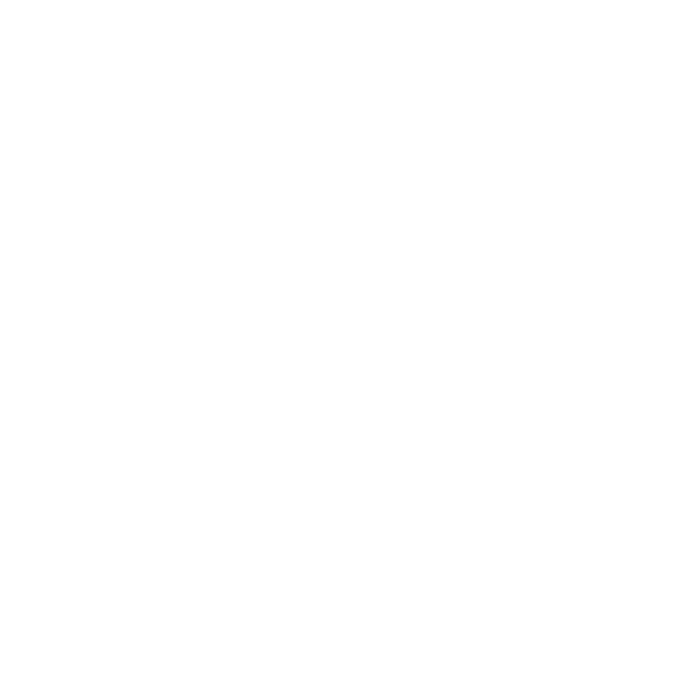

popt= [ 1.60022289e-04  1.76452303e-03 -6.11585956e+00  4.82561204e+00]


<IPython.core.display.Javascript object>


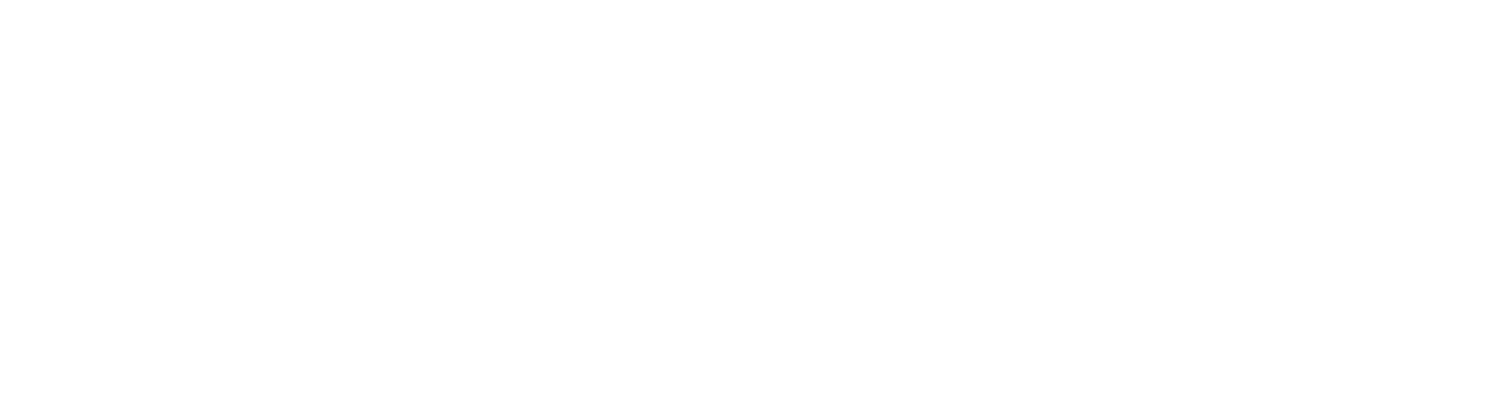

Current tilt (°) is -2.0604 . Rotate 2.4396 to get to target of  -4.5



<IPython.core.display.Javascript object>


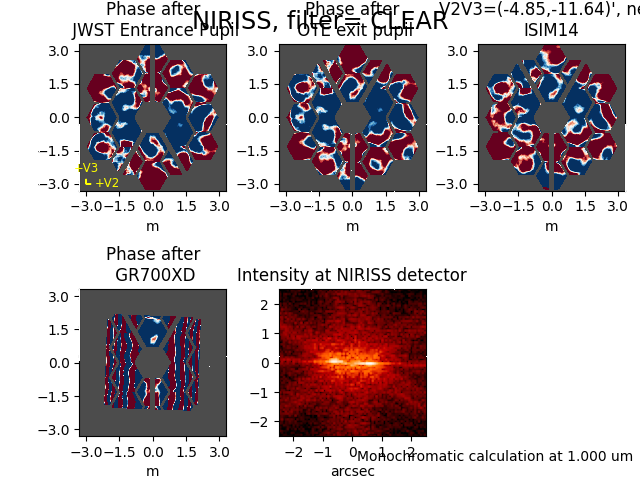

In [62]:
# Test the whole process for one 1 file

PSF_arg = 1.0e-6
wanted_tilt = -4.5
kwargs = {}

################## Initiate kwargs if not already present #############################
if 'psf_dim' not in kwargs:     kwargs['psf_dim'] = 128
if 'psf_pad_dim' not in kwargs: kwargs['psf_pad_dim'] = 160
if 'oversamp' not in kwargs:    kwargs['oversamp'] = 10
if 'view' not in kwargs:        kwargs['view'] = 'dtect'
if 'doPlot' not in kwargs:      kwargs['doPlot'] = True
if 'doPrint' not in kwargs:     kwargs['doPrint'] = True

# Initiate args for 'get_webbpsf' if not already present in kwargs
#if 'instrument' not in kwargs:     kwargs['instrument'] = 'NIRISS'
#if 'filter' not in kwargs:         kwargs['filter'] = 'CLEAR'
#if 'pupil_mask' not in kwargs:     kwargs['pupil_mask'] = 'GR700XD'
#if 'pupil_opd_file' not in kwargs: kwargs['pupil_opd_file'] = 'OPD_RevW_ote_for_NIRISS_predicted.fits.gz'
#if 'wfe_real' not in kwargs:       kwargs['wfe_real'] = 0
#if 'jitter' not in kwargs:         kwargs['jitter'] = None
#if 'jitter_sigma' not in kwargs:   kwargs['jitter_sigma'] = 0.0

# Initiate args for 'get webbpsf_tilt' if not already present in kwargs
if 'mode' not in kwargs:         kwargs['tilt_measurement_mode'] = 'ccf'
if 'spatbox_size' not in kwargs: kwargs['spatbox_size'] = 23
if 'specbox_size' not in kwargs: kwargs['specbox_size'] = 20

generate_and_rotate_webbpsf( PSF_arg , wanted_tilt
                  , save=False , savepath=None , **kwargs )

<IPython.core.display.Javascript object>


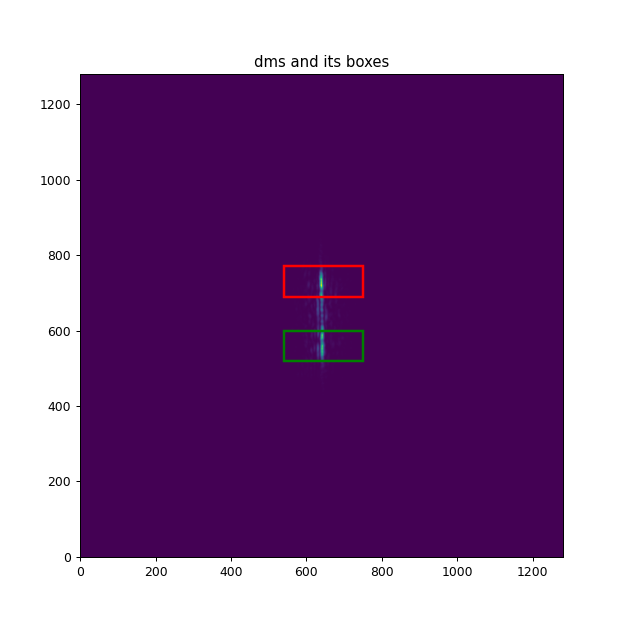

popt= [1.61477732e-04 1.84011627e-03 2.00282931e+00 4.59347027e+00]


<IPython.core.display.Javascript object>


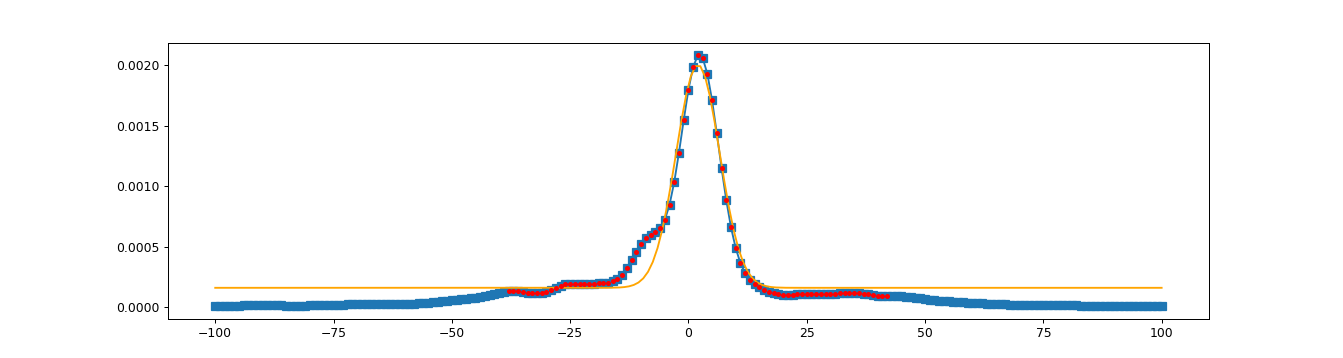

<IPython.core.display.Javascript object>


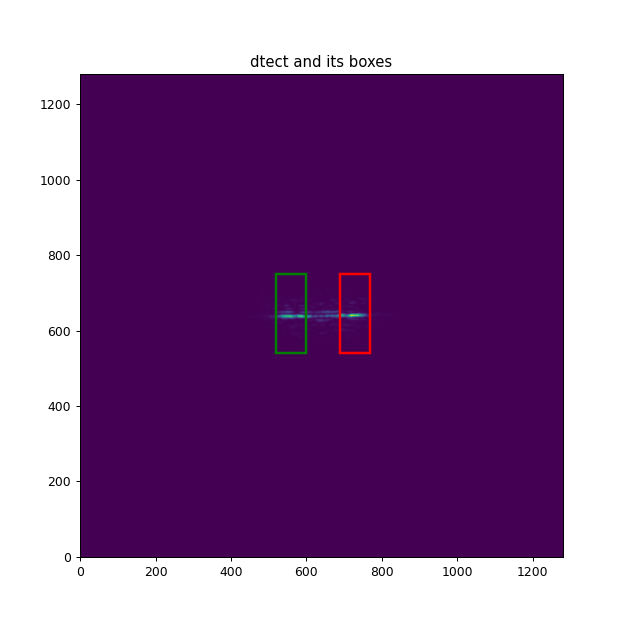

popt= [1.61469605e-04 1.84011874e-03 2.00282177e+00 4.59348415e+00]


<IPython.core.display.Javascript object>


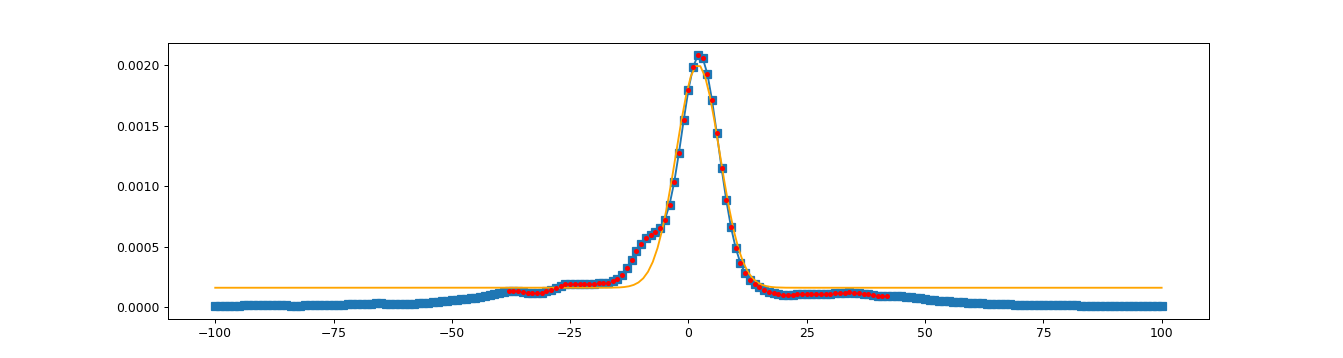

Native tilt =  -0.6749877999931188
DMS tilt = -0.674990338327466
diff =     2.538334347268467e-06


In [29]:
# Test the code for getting a webbPSF
if False:
    get_webbpsf( wavelist=1.5e-6 , save=False , savepath=None
               , doPrint=True , doPlot=True , psf_dim=128)

# Test if getting tilt for detector and DMS views are the same   
if True:
    psf_dir = "/genesis/jwst/jwst-ref-soss/monochromatic_PSFs/"
    psf_name = "SOSS_os10_128x128_1.000000_wfe0.fits"
    tilt_dms = get_webbpsf_tilt(psf_dir+psf_name , view='dms' , doPlot=True)
    with fits.open(psf_dir+psf_name) as the_psf:
        psf_dat = the_psf[0].data
    psf_dat = np.transpose( np.flip(psf_dat,axis=1) )
    tilt_dtect = get_webbpsf_tilt(psf_dat , view='dtect' , doPlot=True)
    print("Native tilt = " , tilt_dtect)
    print("DMS tilt =" , tilt_dms)
    print("diff =    " , tilt_dtect - tilt_dms)

tilt = 2.6507064174377954


<IPython.core.display.Javascript object>


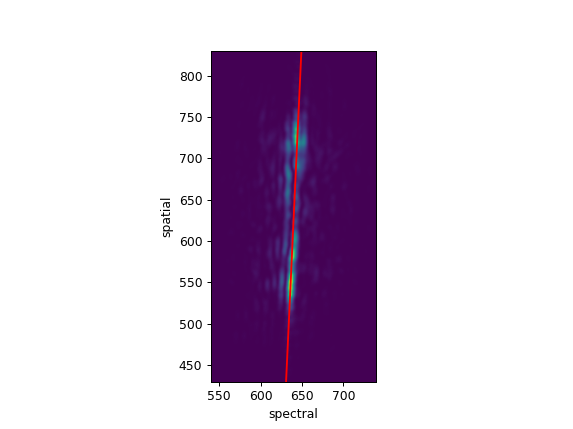

In [118]:
# Test to see if the fit for the tilt is good

psf_dir = "/genesis/jwst/jwst-ref-soss/monochromatic_PSFs/"
psf_name = "SOSS_os10_128x128_1.000000.fits"
with fits.open(psf_dir+psf_name) as a:
    psf = a[0].data

dms = True
if dms:
    psf = np.flip( np.transpose(psf),axis=1 )
    
tilt = get_webbpsf_tilt(psf , view=('dms' if dms else 'dtect'))
print('tilt =',tilt)
spec1 = 540; spec2 = 740
spat1 = 450; spat2 = 850
#dy = np.tan(np.deg2rad(tilt)) * (spat2-spat1)
#print('dy =',dy)
#x1 = spat1; x2 = spat2
#y1 = (spec2+spec1)/2 - dy/2
#y2 = (spec2+spec1)/2 + dy/2
    
plt.figure()
if dms:
    size = psf.shape[1]
    extent = [ spec1,spec2 , size-spat2,size-spat1 ]
    plt.imshow(psf[size-spat2:size-spat1+1,spec1:spec2+1],origin='lower' , extent=extent)
    plt.xlabel('spectral'); plt.ylabel('spatial')
    dx = np.tan(np.deg2rad(tilt)) * (spat2-spat1)
    #print('dx =',dx)
    x1 = np.mean([spec1,spec2]) - dx/2
    x2 = np.mean([spec1,spec2]) + dx/2
    y1 = size - spat2;  y2 = size - spat1
    #print( (x1,x2) , " , " , (y1,y2) )
    plt.plot([x1,x2],[y1,y2],c='r')
else:
    extent = [ spat1,spat2 , spec1,spec2 ]
    plt.imshow(psf[spec1:spec2+1,spat1:spat2+1],origin='lower' , extent=extent)
    plt.xlabel('spatial'); plt.ylabel('spectral')
    dy = np.tan(np.deg2rad(tilt)) * (spat2-spat1)
    #print('dy =',dy)
    x1 = spat1; x2 = spat2
    y1 = np.mean([spec1,spec2]) + dy/2
    y2 = np.mean([spec1,spec2]) - dy/2
    plt.plot([x1,x2],[y1,y2],c='r')


#plt.figure()
#plt.plot(psf[spec1:spec2+1,750])

#plt.figure()
#plt.imshow( np.flip( np.transpose(psf),axis=1 ) , origin='lower')

In [123]:
# Check if padded and un-padded webbpsf are equal

wav = 1.4e-6
view = 'dms'
os = 10
dim = 128
pad_dim = 160
jitter = 'gaussian';  jitter_sigma = 0.007
#jitter = None;  jitter_sigma = 0.0

psf = get_webbpsf( wav , view=view , return_fits_HDUL=False
                 , doPrint=False , doPlot=False
                 , psf_dim = dim , jitter=jitter , jitter_sigma=jitter_sigma)
psf_pad = get_webbpsf( wav , view=view , return_fits_HDUL=False
                     , doPrint=False , doPlot=False
                     , psf_dim = pad_dim , )

<IPython.core.display.Javascript object>


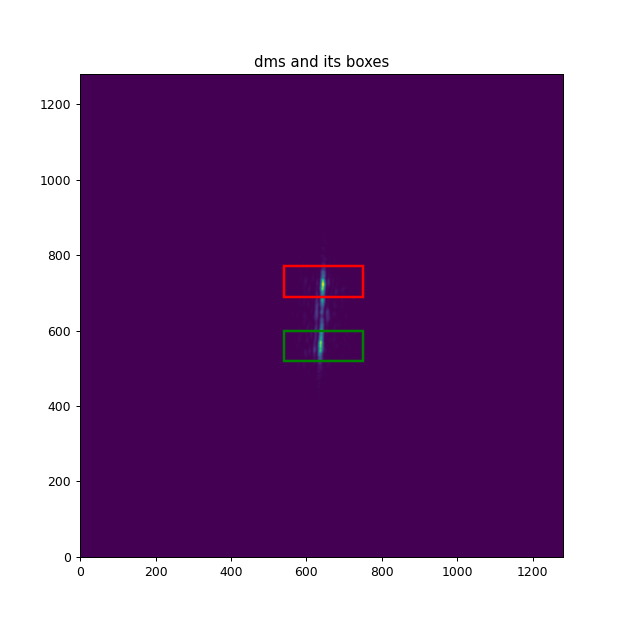

popt= [1.09074688e-04 1.67791247e-03 5.90574310e+00 5.82910490e+00]


<IPython.core.display.Javascript object>


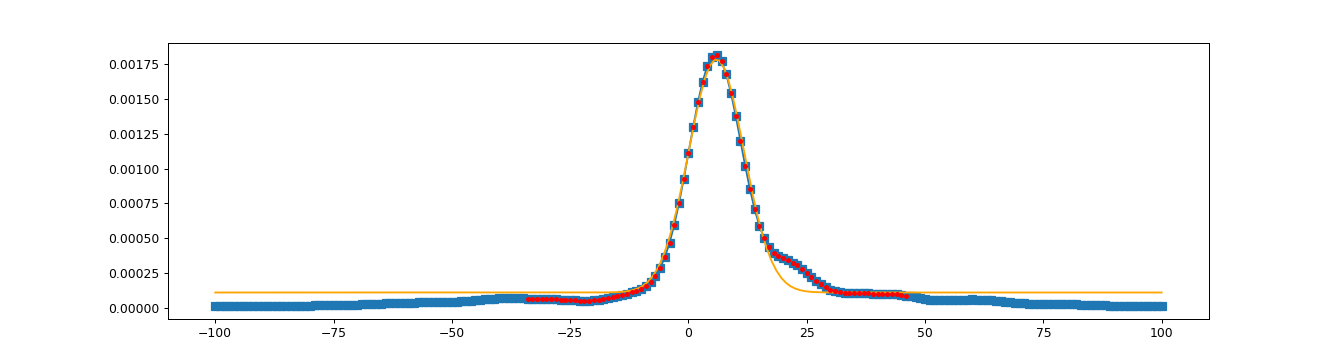

<IPython.core.display.Javascript object>


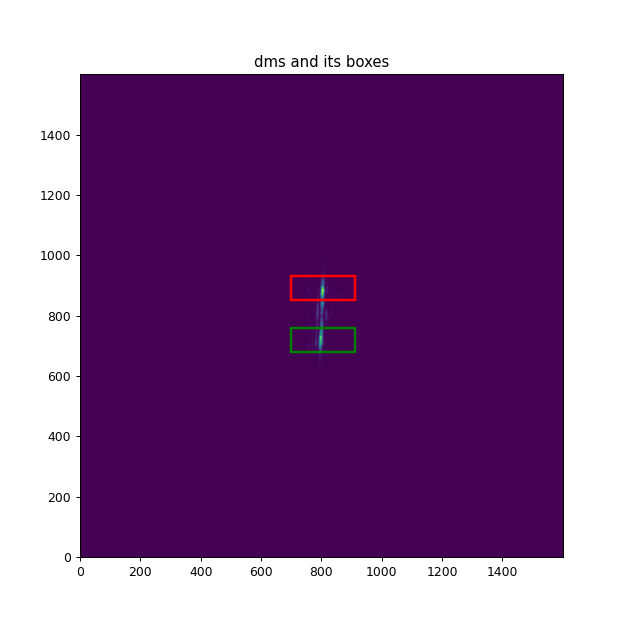

popt= [1.11822658e-04 1.74698513e-03 5.86224064e+00 5.55523105e+00]


<IPython.core.display.Javascript object>


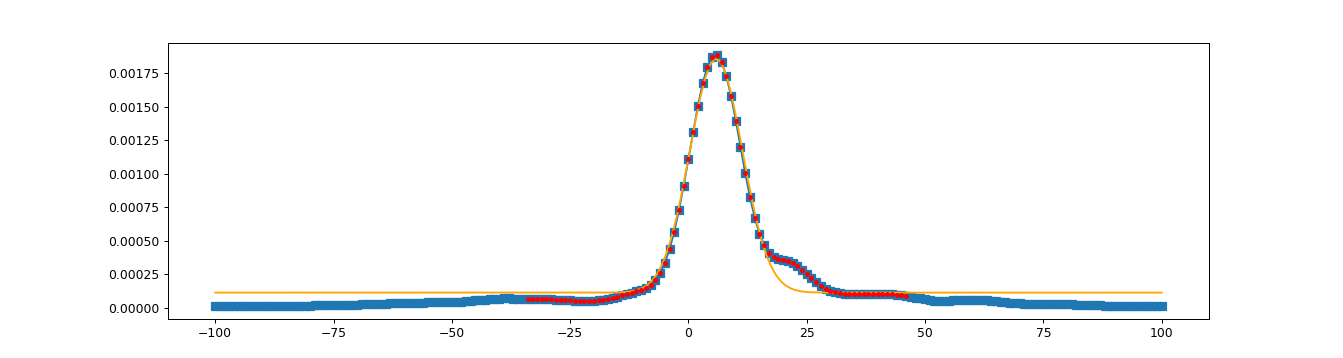

<IPython.core.display.Javascript object>


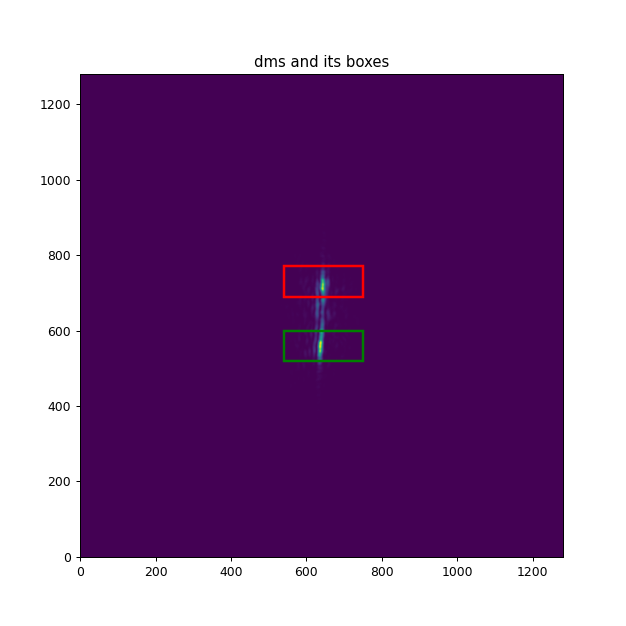

popt= [1.21916940e-04 1.27337300e-03 6.83707632e+00 7.89772724e+00]


<IPython.core.display.Javascript object>


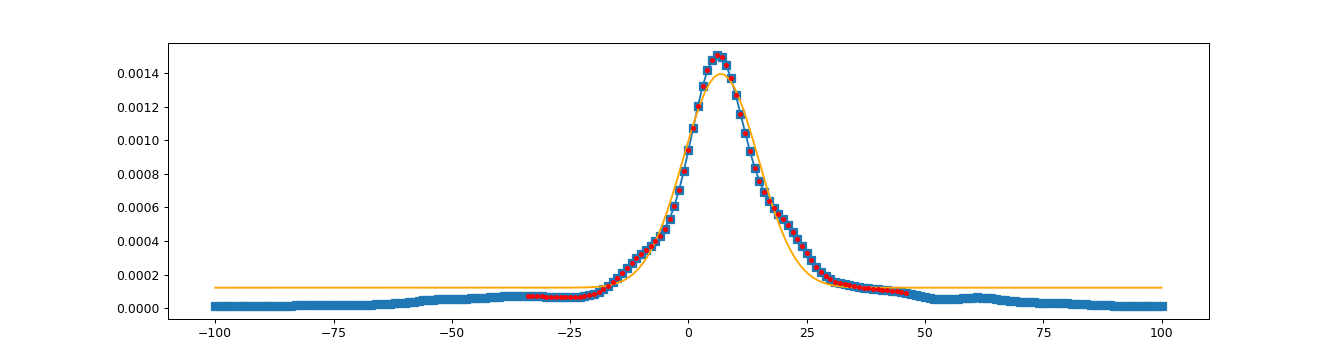

1.9896360673885984
1.9749918035155136
2.3030859509214507


<IPython.core.display.Javascript object>


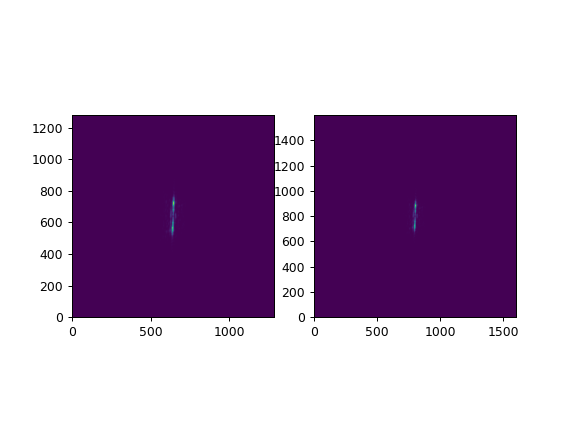

<IPython.core.display.Javascript object>


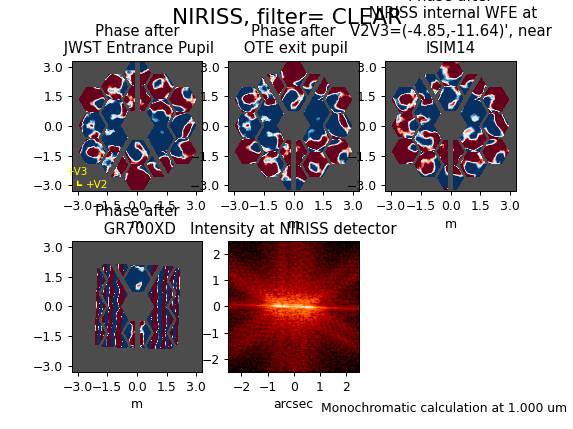

In [124]:
# continued...

with fits.open("/genesis/jwst/jwst-ref-soss/monochromatic_PSFs/"+"SOSS_os10_128x128_1.400000.fits") as h:
    psf_fits = h[0].data
    psf_fits = np.flip( np.transpose(psf_fits) , axis=1 )

tilt = get_webbpsf_tilt( psf , oversamp=os , view=view , doPlot=True )
tilt_pad = get_webbpsf_tilt( psf_pad , oversamp=os , view=view , doPlot=True )
tilt_fits = get_webbpsf_tilt( psf_fits , oversamp=os , view=view , doPlot=True )
print(tilt)
print(tilt_pad)
print(tilt_fits)

plt.figure()
plt.subplot(1,2,1);  plt.imshow(psf , origin='lower')
plt.subplot(1,2,2);  plt.imshow(psf_pad , origin='lower')

center = int(psf_pad.shape[0]/2)
slyce = slice( center-int(os*dim/2) , center+int(os*dim/2) )
resi = ((psf - psf_fits)*1e6)/psf_fits# psf_pad[ slyce,slyce ]
plt.figure()
plt.imshow(resi , origin='lower')
plt.colorbar()

if False:
    print()#h = fits.PrimaryHDU(psf)
    #h.writeto("/genesis/jwst/jwst-ref-soss/monochromatic_PSFs/SOSS_os10_128x128_1.400000_Frost.fits")

Calculating PSF at wavelength  1.0  microns


<IPython.core.display.Javascript object>


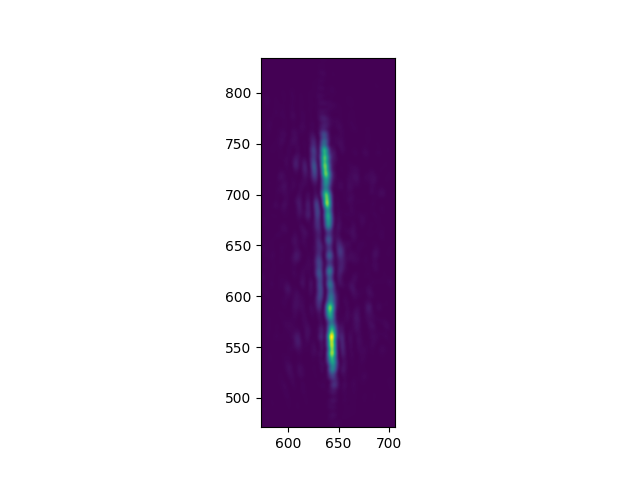

In [85]:
if True:
    wav = 1.0e-6
    view = 'dms'
    os = 10
    dim = 128
    pad_dim = 160
    jitter = 'gaussian';  jitter_sigma = 0.007
    
    psf = get_webbpsf( wav , view=view , oversamp=os
                     , doPrint=True , doPlot=False , save=False, savepath=None
                     , psf_dim = dim , jitter=jitter , jitter_sigma=jitter_sigma)
    plt.figure()
    plt.imshow(psf[0].data,origin='lower')

Calculating PSF at wavelength  2.3000000000000003  microns


<IPython.core.display.Javascript object>


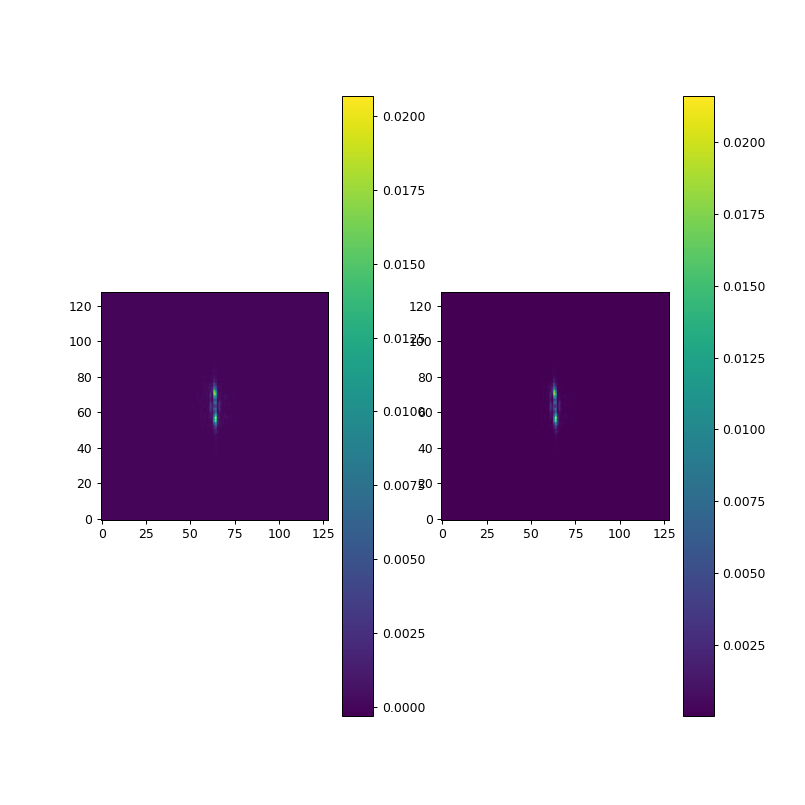

In [112]:
if True:
    wav = 2.3e-6
    view = 'dms'
    os = 1
    dim = 128
    pad_dim = 160
    jitter = 'gaussian';  jitter_sigma = 0.007
    
    psf = get_webbpsf( wav , view=view , oversamp=os
                     , doPrint=True , doPlot=False , save=False, savepath=None
                     , psf_dim = dim , jitter=jitter , jitter_sigma=jitter_sigma)
    plt.figure(figsize=(9,9))
    plt.subplot(1,2,1)
    #plt.imshow(psf[0].data , origin='lower')
    extent1 = [ int(pad_dim/2 - dim/2) , int(pad_dim/2 + dim/2) , int(pad_dim/2 - dim/2) , int(pad_dim/2 + dim/2) ]
    #plt.imshow(np.full((dim,dim),1e3) , origin='lower' , extent=extent1)#[16,144,16,144] )
    plt.imshow(ndimage.rotate(psf[0].data , 1,reshape=False),origin='lower' )#, extent=[0,pad_dim,0,pad_dim])
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(psf[0].data, origin='lower')
    plt.colorbar()

Filename: /genesis/jwst/jwst-ref-soss/monochromatic_PSFs/psf_20210627_Frost/SOSS_os10_128x128_0.500000_wfe0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU      94   (1280, 1280)   float64   
  1  DET_SAMP      1 ImageHDU        95   (160, 160)   float64   
  2  OVERDIST      1 ImageHDU       127   (1600, 1600)   float64   
  3  DET_DIST      1 ImageHDU       128   (160, 160)   float64   

('SIMPLE', True)
('BITPIX', -64)
('NAXIS', 2)
('NAXIS1', 1280)
('NAXIS2', 1280)
('EXTEND', True)
('PLANE1', 'Wavefront Intensity')
('WAVELEN', 5e-07)
('DIFFLMT', 0.01561792464130162)
('OVERSAMP', 10)
('DET_SAMP', 10)
('PIXELSCL', 0.00656)
('FOV', 10.496)
('NWAVES', 1)
('WAVE0', 5e-07)
('WGHT0', 1)
('FFTTYPE', 'pyFFTW')
('NORMALIZ', 'first')
('JITRTYPE', 'Gaussian convolution')
('JITRSIGM', 0.007)
('JITRSTRL', 0.784448040031939)
('PUPILINT', 'jwst_pupil_RevW_npix1024.fits.gz')
('PUPILOPD', 'OPD_RevW_ote_for_NIRISS_predicted.fits.gz slice 0')
('OPD_FIL

<IPython.core.display.Javascript object>


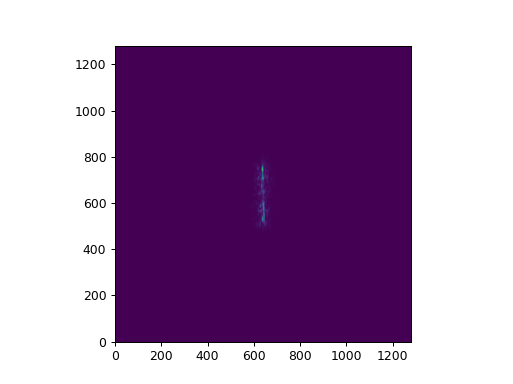

In [6]:
path = "/genesis/jwst/jwst-ref-soss/monochromatic_PSFs/psf_20210627_Frost/"
#path = ""
name = "SOSS_os10_128x128_0.500000_wfe0.fits"
with fits.open(path+name) as a:
    a.info()
    print()
    for head in a[0].header.items():
        print(head)
    print()
    print(a[0].data.shape)
    plt.figure()
    plt.imshow( a[0].data , origin='lower' )